In [47]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2,  mutual_info_classif
import pandas as pd
import numpy as np
import json
import statistics as stats
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

In [48]:
def DBScanAnalyze(PCAs, target, eps, ms):

    PCAs = StandardScaler().fit_transform(PCAs)
    cluster = DBSCAN(eps=eps, min_samples = ms)
    label = cluster.fit_predict(PCAs)
    data = pd.DataFrame({
        'labels': label,
        'count': [1] * len(label),
        'classification': target
    })
    print(f"##### DBScan(eps = {eps}, min_samples = {ms})")
    print("homogeneity_score", homogeneity_score(target, label))
    print("completeness_score", completeness_score(target, label))
    print("v_measure_score", v_measure_score(target, label, beta=0.6))
    print(data.groupby('labels').agg(
        {'count': 'count', 'classification': 'mean'}
    ))
    sns.scatterplot(x=PCAs[:,0], y=PCAs[:,1], hue=label, palette='bright', legend = False)
    plt.show()

    return label

In [25]:
def distance_analyze(data, target, metric):
    data = StandardScaler().fit_transform(data)
    neigh = NearestNeighbors(n_neighbors=2, metric = metric)
    nbrs = neigh.fit(data)
    distances, indexes = nbrs.kneighbors(data)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    plt.figure(figsize=(6,6))
    plt.plot(distances)

    connect = np.zeros(len(indexes)) 
    for i, (x, y) in enumerate(indexes):
        connect[i] = target[x] == target[y]

    plt.title(f"""
        K-distance Graph {metric}
        Homo: {np.sum(connect)/len(connect)}
        P: {np.percentile(distances, [10, 25, 50, 75, 90])}
    """, fontsize=10)
    plt.xlabel('Data Points sorted by distance',fontsize=14)
    plt.ylabel('Epsilon',fontsize=14)

    plt.show()

In [52]:
from random import randint, uniform

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred = y_pred > 0.5
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy.round(2)}")
    
    conf_mat = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n{conf_mat}")

    try:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"AUC-ROC: {roc_auc.round(2)}")
    except:
        try: 
            y_pred_prob = model.predict(X_test, verbose=False)
            roc_auc = roc_auc_score(y_test, y_pred_prob)
            print('AUC-ROC:', roc_auc.round(2))
        except:
            pass

def predict(X_train, y_train, X_test, y_test, columns):
    model = LGBMClassifier(
        colsample_bytree = 0.4741738290873252,
        learning_rate = 0.09783416065100148,
        max_depth = 47,
        min_child_samples = 85,
        min_child_weight = 0.4734717707805657,
        min_split_gain = 0.17320186991001518,
        num_leaves = 95,
        reg_alpha = 0.6497736826427634,
        reg_lambda = 0.048058924197033726,
        subsample = 0.9745728657956929,
        subsample_for_bin = 197379,
        subsample_freq = 33,
        verbose = -1
    )

    model.fit(X_train[columns].to_numpy(), y_train)
    test_model(model, X_test[columns].to_numpy(), y_test)

In [27]:
def compose(csv, prefix = ''):

    df  = pd.read_csv(f"{csv}.csv")

    target = df['tgt']
    sequences = df['src'].apply(json.loads)

    min_index = np.min(sequences.apply(min))
    max_index = np.max(sequences.apply(max))
    min_index, max_index, len(sequences)

    origin_df = df.drop(['tgt', 'src', 'Unnamed: 0', 'src_bio_57'], axis=1)

    count_df = pd.read_csv(f'count{prefix}_PCA.csv')
    first_df = pd.read_csv(f'first{prefix}_PCA.csv')
    # last_df = pd.read_csv(f'last{prefix}_PCA.csv')
    left_df = pd.read_csv(f'left{prefix}_PCA.csv')
    right_df = pd.read_csv(f'right{prefix}_PCA.csv')
    max_dist_df = pd.read_csv(f'max_dist{prefix}_PCA.csv')
    min_dist_df = pd.read_csv(f'min_dist{prefix}_PCA.csv')
    gaussian = pd.read_csv(f'gaussian{prefix}.csv')
    gaussian_bio = pd.read_csv(f'gaussian{prefix}_bio.csv')
    
    df = pd.concat([
        count_df, 
        first_df,
        origin_df,
        left_df,
        right_df,
        max_dist_df,
        min_dist_df,
        gaussian,
        gaussian_bio
    ], axis=1)
    
    
    df['lenght'] = sequences.apply(len)
    df['firts'] = sequences.apply(lambda x: x[0])
    df['last'] = sequences.apply(lambda x: x[-1])
    df['modes'] = sequences.apply(stats.mode)
    
    return df, target

In [28]:
X_train, y_train = compose('train')
X_test, y_test = compose('test', '_test')

In [29]:
X_train

,count_PC1,count_PC2,count_PC3,count_PC4,count_PC5,count_PC6,count_PC7,count_PC8,count_PC9,count_PC10,...,"bio-GaussianMixture(comp=7, cov_type=tied)","bio-GaussianMixture(comp=7, cov_type=diag)","bio-GaussianMixture(comp=8, cov_type=spherical)","bio-GaussianMixture(comp=8, cov_type=full)","bio-GaussianMixture(comp=8, cov_type=tied)","bio-GaussianMixture(comp=8, cov_type=diag)",lenght,firts,last,modes
0,6.392605,-0.087228,-0.178836,-1.634709,0.022571,-2.528708,1.398683,1.891864,-0.755806,-1.449389,...,5,5,7,7,2,4,591,1,13,9
1,0.823412,-0.381487,2.097485,-0.425537,-0.011001,0.366646,-0.889388,-0.948390,0.064099,-0.463419,...,0,0,2,3,4,6,322,1,12,5
2,-3.455502,-0.346474,0.407845,-0.044280,0.447581,-0.198031,0.214892,-0.034313,0.115289,0.424723,...,3,0,2,5,4,5,135,1,16,14
3,2.054727,0.325222,-0.439583,-0.003690,0.507338,-0.707984,0.102233,-1.824386,-0.053031,-0.290162,...,0,0,1,3,1,6,388,1,13,5
4,3.543827,-0.286260,-0.162030,0.518870,0.524005,-0.009828,-0.349300,0.474786,0.851644,0.092356,...,3,0,5,0,4,6,468,1,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62473,-4.325469,-0.122856,0.418878,0.163673,0.320074,-0.614906,0.415270,0.494983,-0.178649,-0.617295,...,6,1,3,1,3,2,97,1,22,14
62474,-2.229256,0.067708,-0.395153,0.661939,-0.325518,0.081326,0.161364,-0.911487,0.027498,-0.555537,...,0,5,6,6,1,4,194,1,16,4
62475,-4.964628,0.456935,-0.247010,0.225986,0.093337,-0.277905,-0.149737,-0.088202,-0.065597,0.126066,...,6,4,3,1,3,7,72,1,20,10
62476,-3.498188,0.478849,-0.340330,0.535652,0.046766,-0.576583,-0.256736,-0.091096,0.102754,-0.299483,...,3,3,0,3,4,1,139,1,4,11


In [30]:
X_test

,count_PC1,count_PC2,count_PC3,count_PC4,count_PC5,count_PC6,count_PC7,count_PC8,count_PC9,count_PC10,...,"bio-GaussianMixture(comp=7, cov_type=tied)","bio-GaussianMixture(comp=7, cov_type=diag)","bio-GaussianMixture(comp=8, cov_type=spherical)","bio-GaussianMixture(comp=8, cov_type=full)","bio-GaussianMixture(comp=8, cov_type=tied)","bio-GaussianMixture(comp=8, cov_type=diag)",lenght,firts,last,modes
0,-2.735653,0.298793,0.110405,-0.127494,0.460049,0.235577,-0.346436,-0.298222,-0.021408,0.389574,...,3,4,3,2,4,7,156,1,18,10
1,-2.522907,0.310875,0.482410,-0.090676,0.580272,-0.031719,0.377921,-0.159317,-0.623596,-0.466123,...,3,4,3,2,4,7,165,1,11,4
2,6.407377,5.452725,-3.201628,1.188621,0.162254,-0.235460,-2.007740,0.168795,-3.363017,0.408749,...,3,4,3,2,4,4,607,1,17,12
3,-0.956036,0.239799,-0.332847,-0.092546,-0.470998,-0.758532,-0.383273,1.230850,-0.107472,-0.298048,...,3,4,3,2,4,4,245,1,19,7
4,5.469015,0.041530,-1.351360,1.533231,-0.004220,0.977673,-0.313051,1.454216,0.385337,-0.273169,...,3,4,3,2,4,4,561,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,3.159009,2.459616,-1.373349,-0.692110,-0.167758,0.125898,-1.130111,-0.064315,-0.962131,-0.502275,...,3,4,3,2,4,4,469,1,6,11
1995,-4.692184,0.010824,0.299321,-0.011419,0.348910,0.462853,0.177063,0.386837,-0.038916,-0.083565,...,3,4,3,2,4,7,48,1,13,4
1996,4.709906,1.306537,0.443219,-0.570511,-0.838177,-1.150814,2.041621,-0.517249,-0.988591,-1.698225,...,3,4,3,2,4,4,552,1,19,4
1997,-3.403748,-0.163791,-0.448341,-0.520371,0.152810,-0.088930,-0.378637,0.106167,-0.309731,-0.153038,...,3,4,3,2,4,4,126,1,5,5


/Users/dany/.local/share/virtualenvs/python-ai-env-cTwd-LQ7/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [264] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dany/.local/share/virtualenvs/python-ai-env-cTwd-LQ7/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


['first_PC3' 'src_bio_9' 'src_bio_12' 'src_bio_13' 'src_bio_15'
 'src_bio_24' 'src_bio_25' 'src_bio_26' 'src_bio_27' 'src_bio_28'
 'src_bio_29' 'src_bio_30' 'src_bio_31' 'src_bio_32' 'src_bio_33'
 'src_bio_34' 'src_bio_35' 'src_bio_36' 'src_bio_37' 'src_bio_46'
 'src_bio_47' 'src_bio_48' 'src_bio_49' 'src_bio_50' 'src_bio_51'
 'src_bio_52' 'src_bio_53' 'src_bio_54' 'src_bio_55' 'src_bio_56'
 'first-GaussianMixture(comp=4, cov_type=spherical)'
 'first-GaussianMixture(comp=5, cov_type=spherical)'
 'first-GaussianMixture(comp=5, cov_type=tied)'
 'first-GaussianMixture(comp=6, cov_type=spherical)'
 'first-GaussianMixture(comp=6, cov_type=tied)'
 'bio-GaussianMixture(comp=2, cov_type=spherical)'
 'bio-GaussianMixture(comp=2, cov_type=full)'
 'bio-GaussianMixture(comp=2, cov_type=tied)'
 'bio-GaussianMixture(comp=2, cov_type=diag)'
 'bio-GaussianMixture(comp=3, cov_type=full)'
 'bio-GaussianMixture(comp=3, cov_type=tied)'
 'bio-GaussianMixture(comp=4, cov_type=spherical)'
 'bio-GaussianMixtu

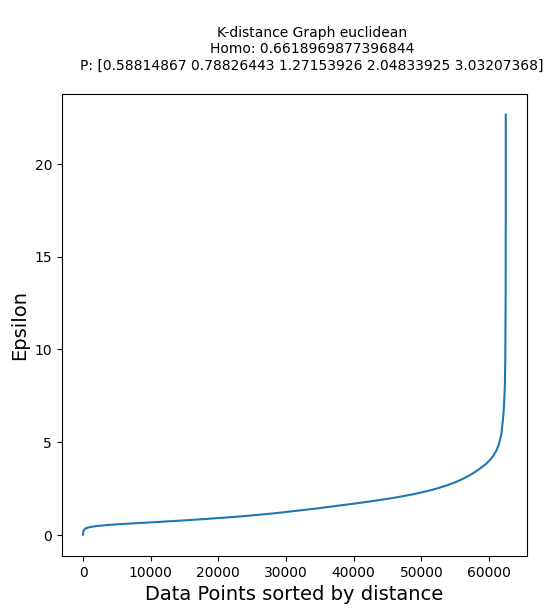

In [41]:
selector = SelectKBest(score_func=f_classif, k=56)
# Aplicar el selector a los datos
X_new = selector.fit_transform(X_train, y_train)
columns = selector.get_feature_names_out()
print(columns)

distance_analyze(X_train[columns].to_numpy(), y_train, metric='euclidean')

##### DBScan(eps = 4, min_samples = 5)
homogeneity_score 0.025497965983039297
completeness_score 0.07988183857658057
v_measure_score 0.03423931370779392
        count  classification
labels                       
-1       3183        0.802388
 0      59197        0.396118
 1         16        0.750000
 2         18        0.944444
 3          9        0.666667
 4          3        0.333333
 5          5        0.800000
 6          5        0.800000
 7          2        0.000000
 8          6        0.833333
 9          6        1.000000
 10         5        0.000000
 11         5        1.000000
 12         5        0.800000
 13         5        0.600000
 14         4        0.750000
 15         4        0.500000


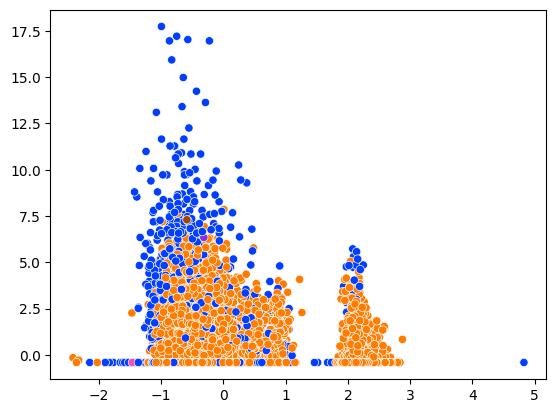

['first_PC3' 'src_bio_9' 'src_bio_12' 'src_bio_13' 'src_bio_15'
 'src_bio_24' 'src_bio_25' 'src_bio_26' 'src_bio_27' 'src_bio_28'
 'src_bio_29' 'src_bio_30' 'src_bio_31' 'src_bio_32' 'src_bio_33'
 'src_bio_34' 'src_bio_35' 'src_bio_36' 'src_bio_37' 'src_bio_46'
 'src_bio_47' 'src_bio_48' 'src_bio_49' 'src_bio_50' 'src_bio_51'
 'src_bio_52' 'src_bio_53' 'src_bio_54' 'src_bio_55' 'src_bio_56'
 'first-GaussianMixture(comp=4, cov_type=spherical)'
 'first-GaussianMixture(comp=5, cov_type=spherical)'
 'first-GaussianMixture(comp=5, cov_type=tied)'
 'first-GaussianMixture(comp=6, cov_type=spherical)'
 'first-GaussianMixture(comp=6, cov_type=tied)'
 'bio-GaussianMixture(comp=2, cov_type=spherical)'
 'bio-GaussianMixture(comp=2, cov_type=full)'
 'bio-GaussianMixture(comp=2, cov_type=tied)'
 'bio-GaussianMixture(comp=2, cov_type=diag)'
 'bio-GaussianMixture(comp=3, cov_type=full)'
 'bio-GaussianMixture(comp=3, cov_type=tied)'
 'bio-GaussianMixture(comp=4, cov_type=spherical)'
 'bio-GaussianMixtu

In [50]:
predict(X_train, y_train, X_test, y_test, columns)
labels = DBScanAnalyze(X_train[columns].to_numpy(), y_train, eps=4, ms=5)
predict(X_train[labels != -1], y_train[labels != -1], X_test, y_test, columns)

['src_bio_0' 'src_bio_2' 'src_bio_5' 'src_bio_6' 'src_bio_7' 'src_bio_8'
 'src_bio_9' 'src_bio_10' 'src_bio_11' 'src_bio_12' 'src_bio_13'
 'src_bio_14' 'src_bio_15' 'src_bio_16' 'src_bio_17' 'src_bio_19'
 'src_bio_20' 'src_bio_21' 'src_bio_24' 'src_bio_25' 'src_bio_26'
 'src_bio_27' 'src_bio_28' 'src_bio_29' 'src_bio_30' 'src_bio_31'
 'src_bio_33' 'src_bio_34' 'src_bio_35' 'src_bio_36' 'src_bio_38'
 'src_bio_39' 'src_bio_40' 'src_bio_41' 'src_bio_46' 'src_bio_50'
 'src_bio_52' 'src_bio_53' 'src_bio_54' 'src_bio_55' 'src_bio_56'
 'count-GaussianMixture(comp=2, cov_type=tied)'
 'first-GaussianMixture(comp=2, cov_type=spherical)'
 'first-GaussianMixture(comp=2, cov_type=full)'
 'first-GaussianMixture(comp=2, cov_type=tied)'
 'first-GaussianMixture(comp=2, cov_type=diag)'
 'first-GaussianMixture(comp=3, cov_type=spherical)'
 'first-GaussianMixture(comp=3, cov_type=tied)'
 'first-GaussianMixture(comp=4, cov_type=tied)'
 'first-GaussianMixture(comp=5, cov_type=spherical)'
 'first-GaussianMix

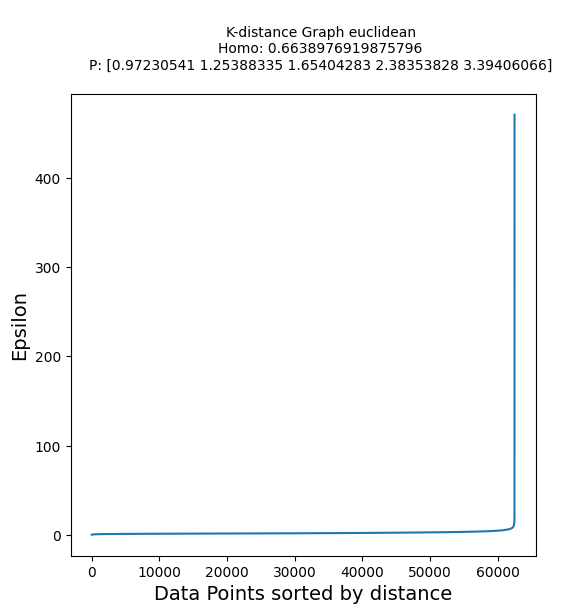

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Crear un objeto RFE con el estimador a utilizar y el número de características finales a mantener
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=56)

# Aplicar el selector a los datos
X_new = selector.fit_transform(X_train, y_train)

columns = selector.get_feature_names_out()
print(columns)

distance_analyze(X_train[columns].to_numpy(), y_train, metric='euclidean')

In [ ]:
predict(X_train, y_train, X_test, y_test, columns)
labels = DBScanAnalyze(X_train[columns].to_numpy(), y_train, eps=4, ms=5)
predict(X_train[labels != -1], y_train[labels != -1], X_test, y_test, columns)

In [9]:
from sklearn.linear_model import RidgeCV

# Crear un objeto de Regresión Ridge con validación cruzada para seleccionar el parámetro de regularización
ridge = RidgeCV()

# Ajustar el modelo de Regresión Ridge a los datos
ridge.fit(X_train, y_train)

# Obtener las características con coeficientes no nulos
X_train.columns[ridge.coef_ != 0]

Index(['count_PC1', 'count_PC2', 'count_PC3', 'count_PC4', 'count_PC5',
       'count_PC6', 'count_PC7', 'count_PC8', 'count_PC9', 'count_PC10',
       ...
       'min_dist_PC12', 'min_dist_PC13', 'min_dist_PC14', 'min_dist_PC15',
       'min_dist_PC16', 'min_dist_PC17', 'min_dist_PC18', 'lenght', 'last',
       'modes'],
      dtype='object', length=118)

In [10]:
from sklearn.linear_model import LassoCV

# Crear un objeto de Regresión Lasso con validación cruzada para seleccionar el parámetro de regularización
lasso = LassoCV()

# Ajustar el modelo de Regresión Lasso a los datos
lasso.fit(X_train, y_train)

# Obtener las características con coeficientes no nulos
X_train.columns[lasso.coef_ != 0]

Index(['count_PC3', 'count_PC4', 'count_PC6', 'count_PC8', 'count_PC10',
       'count_PC11', 'first_PC3', 'src_bio_37', 'src_bio_41', 'src_bio_42',
       'src_bio_49', 'src_bio_50', 'max_dist_PC1', 'max_dist_PC2',
       'max_dist_PC3', 'max_dist_PC4', 'max_dist_PC5', 'max_dist_PC7',
       'max_dist_PC8', 'max_dist_PC9', 'max_dist_PC11', 'max_dist_PC13',
       'max_dist_PC14', 'max_dist_PC15', 'max_dist_PC16', 'max_dist_PC17',
       'min_dist_PC1', 'min_dist_PC5', 'min_dist_PC8', 'min_dist_PC11',
       'min_dist_PC15', 'min_dist_PC17', 'min_dist_PC18', 'lenght', 'last',
       'modes'],
      dtype='object')

In [11]:
from sklearn.linear_model import ElasticNetCV

# Crear un objeto de Elastic Net con validación cruzada para seleccionar los parámetros de regularización
enet = ElasticNetCV()

# Ajustar el modelo de Elastic Net a los datos
enet.fit(X_train, y_train)

# Obtener las características con coeficientes no nulos
X_train.columns[enet.coef_ != 0]

Index(['count_PC3', 'count_PC4', 'count_PC6', 'count_PC8', 'count_PC10',
       'count_PC11', 'first_PC3', 'src_bio_13', 'src_bio_37', 'src_bio_41',
       'src_bio_42', 'src_bio_48', 'src_bio_49', 'src_bio_50', 'max_dist_PC2',
       'max_dist_PC3', 'max_dist_PC4', 'max_dist_PC5', 'max_dist_PC7',
       'max_dist_PC8', 'max_dist_PC9', 'max_dist_PC11', 'max_dist_PC13',
       'max_dist_PC14', 'max_dist_PC15', 'max_dist_PC16', 'max_dist_PC17',
       'min_dist_PC1', 'min_dist_PC5', 'min_dist_PC8', 'min_dist_PC11',
       'min_dist_PC15', 'min_dist_PC17', 'min_dist_PC18', 'lenght', 'last',
       'modes'],
      dtype='object')

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular el VIF para cada característica
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Seleccionar las características con VIF por debajo de un umbral predefinido
vif[vif["VIF"] < 5]["Feature"]

4          count_PC5
5          count_PC6
6          count_PC7
7          count_PC8
8          count_PC9
9         count_PC10
10        count_PC11
11         first_PC1
12         first_PC2
13         first_PC3
14         first_PC4
15         first_PC5
16         first_PC6
17         first_PC7
18         first_PC8
21         src_bio_2
24         src_bio_5
75        src_bio_56
81      max_dist_PC2
82      max_dist_PC3
83      max_dist_PC4
84      max_dist_PC5
85      max_dist_PC6
86      max_dist_PC7
87      max_dist_PC8
88      max_dist_PC9
89     max_dist_PC10
90     max_dist_PC11
91     max_dist_PC12
92     max_dist_PC13
93     max_dist_PC14
94     max_dist_PC15
95     max_dist_PC16
96     max_dist_PC17
97      min_dist_PC1
98      min_dist_PC2
99      min_dist_PC3
100     min_dist_PC4
101     min_dist_PC5
102     min_dist_PC6
103     min_dist_PC7
104     min_dist_PC8
105     min_dist_PC9
106    min_dist_PC10
107    min_dist_PC11
108    min_dist_PC12
109    min_dist_PC13
110    min_di

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Crear un objeto de clasificador de Random Forest
clf = RandomForestClassifier()

# Ajustar el clasificador de Random Forest a los datos
clf.fit(X_train, y_train)

# Obtener la importancia de características
importances = clf.feature_importances_

# Seleccionar las características por encima de un umbral predefinido

In [14]:
X_train.columns[importances > 0.01]


Index(['first_PC1', 'first_PC2', 'first_PC3', 'first_PC4', 'first_PC5',
       'first_PC6', 'first_PC7', 'src_bio_15', 'src_bio_28', 'src_bio_29',
       'src_bio_30', 'src_bio_31', 'src_bio_32', 'src_bio_33', 'src_bio_34',
       'src_bio_49', 'src_bio_50', 'src_bio_51', 'src_bio_52', 'last'],
      dtype='object')